In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
from category_encoders import CatBoostEncoder, TargetEncoder

import holidays
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [66]:
def group_season(df):
    df.loc[(df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5), 'season'] = '봄'
    df.loc[(df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8), 'season'] = '여름'
    df.loc[(df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11), 'season'] = '가을'
    df.loc[(df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2), 'season'] = '겨울'
    return df['season']

def holiday(df):
    kr_holidays = holidays.KR()
    df['holiday'] = df.timestamp.apply(lambda x: 'holiday' if x in kr_holidays else 'non-holiday')
    return df['holiday']

def cyclical_feature(df, time=12):
    df['sin_time'] = np.sin(2*np.pi*df.month/time)
    df['cos_time'] = np.cos(2*np.pi*df.month/time)
    
def post_preprocessing(test, submission):
    idx_list = test[(test['Weekday'] == 6)].index 
    submission.loc[idx_list, 'answer'] = 0 # Weekday == 6 (일요일)이면 가격 0원
    submission['answer'] = submission['answer'].apply(lambda x: max(0, x)) # 가격에 음수가 있다면 가격 0원으로 변경
    return submission



# 날짜를 기반으로 주 수확 시기인지를 판단하는 함수를 정의합니다.
def determine_harvest_weight(item, month):
    harvest_times = {
    'TG': {'main': [(10, 1)]},  # 감귤: 10월부터 이듬해 1월까지
    'BC': {'main': [(4, 6), (9, 11)]},  # 브로콜리: 4월-6월, 9월-11월
    'RD': {'main': [(5, 6), (11, 12)]},  # 무: 5월, 11월
    'CR': {'main': [(7, 8), (10, 11)]},  # 당근: 7월-8월, 10월-12월
    'CB': {'main': [(6, 6), (11, 11)]}  # 양배추: 6월, 11월
}
    main_harvest = harvest_times[item]['main']
    for start, end in main_harvest:
        if start <= month <= end:
            return 1
    return 0

In [71]:
class DataPreprocessing:
    def __init__(self, train, test):
        self.train = train
        self.test = test

    @staticmethod
    def label_encode(train, test):
        categorical_col = ['item', 'corporation', 'location', 'season', 'holiday', 'total_item_value',
                           'item_month_Weekday', 'item_corp_Weekday', 'item_location_Weekday', 'item_year_season', 'item_weight']

        for i in categorical_col:
            le = LabelEncoder()
            train[i] = le.fit_transform(train[i])
            test[i] = le.transform(test[i])

        return train, test

    @staticmethod
    def remove_outliers(train):
        print('Remove outliers')
        # Q1 = train['price(원/kg)'].quantile(0.25)
        # Q3 = train['price(원/kg)'].quantile(0.75)
        # IQR = Q3 - Q1

        # lower_bound = Q1 - 1.5 * IQR
        # upper_bound = Q3 + 3 * IQR
        # train = train[(train['price(원/kg)'] >= lower_bound) & (train['price(원/kg)'] <= upper_bound)]
        train.loc[(train['Weekday'] == 6) & (train['price(원/kg)'] >= 0), 'price(원/kg)'] = 0
        return train

    @staticmethod
    def preprocessing(data):
        print('Preprocessing Start')
        # time feature
        data['year'] = data['timestamp'].apply(lambda x: int(x[0:4]))
        data['month'] = data['timestamp'].apply(lambda x: int(x[5:7]))
        data['Weekday'] = pd.to_datetime(data['timestamp']).dt.weekday
        data['is_weekend'] = data['Weekday'].apply(lambda x: 1 if x >= 6 else 0)
        data['year'] = data['year'] - 2019
        data['season'] = group_season(data)
        data['holiday'] = holiday(data)
        cyclical_feature(data)

        # item feature
        data['total_item_value'] = data['item']+data['corporation']+data['location']
        data['item_month_Weekday'] = data['item'].astype(str) + "_" + data['month'].astype(str) + data['Weekday'].astype(str)
        data['item_corp_Weekday'] = data['item'].astype(str) + "_" + data['corporation'].astype(str) + data['Weekday'].astype(str)
        data['item_location_Weekday'] = data['item'].astype(str) + "_" + data['location'].astype(str) + data['Weekday'].astype(str)
        data['item_year_season'] = data['item'].astype(str) + "_" + data['year'].astype(str) + "_" + data['season'].astype(str)

        
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data['harvest_weight'] = data.apply(lambda row: determine_harvest_weight(row['item'], row['timestamp'].month), axis=1)
        data['timestamp'] = data['timestamp'].view('int64') * 1e9

        return data

    def fit(self):
        self.train = self.preprocessing(self.train)
        self.test = self.preprocessing(self.test)

        self.train = self.remove_outliers(self.train)

        x_train = self.train.drop(columns=['ID', 'supply(kg)', 'price(원/kg)'])
        y_train = self.train['price(원/kg)']
        x_test = self.test.drop(columns=['ID'])

        x_train, x_test = self.label_encode(x_train, x_test)

        return x_train, y_train, x_test

In [72]:
train = pd.read_csv(r'./data/train.csv')
international_trade = pd.read_csv(r'./data/international_trade.csv')
test = pd.read_csv(r'./data/test.csv')

In [73]:
preprocessing = DataPreprocessing(train, test)
x, y, test = preprocessing.fit()
train_set = pd.concat([x, y], axis=1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1103)

Preprocessing Start
Preprocessing Start
Remove outliers


RMSE: 852.910079705069
Round RMSE: 852.9050693501782


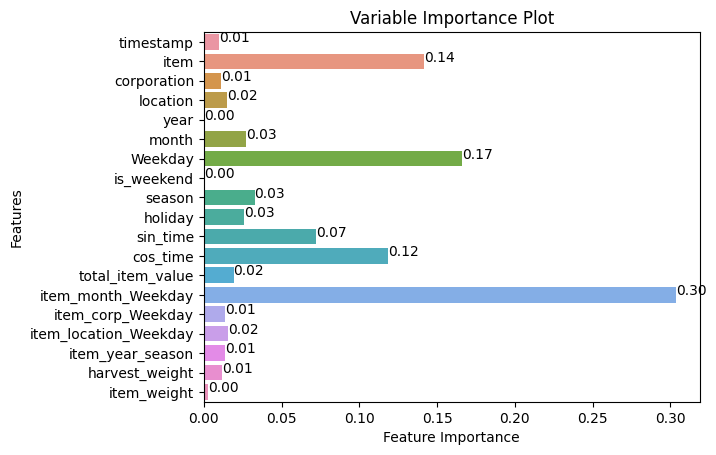

In [74]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_val)
rmse = mean_squared_error(y_val, xgb_pred, squared=False)
round_rmse = mean_squared_error(y_val, np.round(xgb_pred), squared=False)
print(f"RMSE: {rmse}")
print(f"Round RMSE: {round_rmse}")

feature_importance = xgb.feature_importances_
for index, value in enumerate(feature_importance):
    plt.text(value, index, f'{value:.2f}')  # 소수점 둘째 자리까지 표시
sns.barplot(x=feature_importance, y=x_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Variable Importance Plot')
plt.show()

In [75]:
def cross_validate_models(folds, X, y, model, mode='xgb'):

    models = []
    scores = []
    
    for idx, (train_idx, val_idx) in enumerate(folds):
        print(f'===================================={idx+1}============================================')
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        if mode == 'xgb':
            model.fit(x_train, y_train, early_stopping_rounds=50, eval_metric='rmse', eval_set=[(x_val, y_val)], verbose=False)
        if mode == 'lgbm':
            model.fit(x_train, y_train, early_stopping_rounds=50, eval_metric='rmse', eval_set=[(x_val, y_val)], verbose=False)
        if mode == 'cat':
            model.fit(x_train, y_train, early_stopping_rounds=50, verbose=100)
        y_pred = model.predict(x_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        print(f"{idx + 1} Fold RMSE = {rmse}")
        
        scores.append(rmse)
        models.append(model)
        print(f'================================================================================\n\n')
    
    print(f"Average RMSE over {len(folds)} folds: {sum(scores)/len(folds):.4f}")
    
    return models

model = XGBRegressor(n_estimators=10000, random_state=1103)
# model = LGBMRegressor(n_estimators=10000, random_state=1103)
# model = CatBoostRegressor(n_estimators=10000, random_state=1103, cat_features=qual_col)
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1103).split(x, y))
models = cross_validate_models(folds, x, y, model, 'xgb')
predictions = sum(model.predict(test) for model in models) / len(folds)

====================================1============================================
1 Fold RMSE = 846.9039694704007


====================================2============================================
2 Fold RMSE = 846.3419893986365


====================================3============================================
3 Fold RMSE = 870.2446166029446


====================================4============================================
4 Fold RMSE = 854.8054737928107


====================================5============================================
5 Fold RMSE = 847.2919436497037


Average RMSE over 5 folds: 853.1176


In [76]:
predictions

array([ 2990.684  , -1181.0311 ,  5457.516  , ...,   457.75568,
         485.6369 ,   513.61414], dtype=float32)

In [62]:
submission = pd.read_csv(r'data\sample_submission.csv')
submission['answer'] = np.round(predictions)
submission = post_preprocessing(x_test, submission)
submission.to_csv('./lgbm_submission.csv', index=False)

In [107]:
# idx_list = x_test[(x_test['Weekday'] == 6)].index
# submission.loc[idx_list, 'answer'] = 0
# submission['answer'] = submission['answer'].apply(lambda x: max(0, x))